In [2]:
import pyssam
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
import pyssam

import rotation

Read the data

In [4]:
data_dir = "/data/visual/online/projects/LNdW-FaceStats/data/captured_faces_2024/"

data = []
for file in glob.glob(data_dir + "*.txt"):
    data.append(pd.read_csv(file, sep=" ", header=None))
data=np.array(data)
data.shape

(126, 478, 2)

In [5]:
def plot_landmarks(landmark_list,
                   rotated_landmark_list,
                   connections,
                   color,
                   linewidth
                   ):
  """Plot the landmarks and the connections in matplotlib 2d.

  Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.

  Raises:
    ValueError: If any connection contains an invalid landmark index.
  """

  fig,ax = plt.subplots(ncols = 2 , nrows = 1 , figsize = (12,6))
  #plt.figure(figsize=(8, 8))
  #ax = plt.axes()
  plotted_landmarks = {}
  rotated_plotted_landmarks = {}
  for idx, landmark in enumerate(landmark_list):
    plotted_landmarks[idx] = (landmark[0], landmark[1])
  for idx, landmark in enumerate(rotated_landmark_list):
    rotated_plotted_landmarks[idx] = (landmark[0], landmark[1])
  if connections:
    num_landmarks = len(landmark_list)
    # Draws the connections if the start and end landmarks are both visible.
    for connection in connections:
      start_idx = connection[0]
      end_idx = connection[1]
      if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
        raise ValueError(f'Landmark index is out of range. Invalid connection '
                         f'from landmark #{start_idx} to landmark #{end_idx}.')
      if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
        landmark_pair = [
            plotted_landmarks[start_idx], plotted_landmarks[end_idx]
        ]
        rotated_landmark_pair = [
            rotated_plotted_landmarks[start_idx], rotated_plotted_landmarks[end_idx]
        ]
        ax[0].plot(
            [landmark_pair[0][0], landmark_pair[1][0]],
            [landmark_pair[0][1], landmark_pair[1][1]],
            color = color,
            linewidth=linewidth)
        ax[1].plot(
            [rotated_landmark_pair[0][0], rotated_landmark_pair[1][0]],
            [rotated_landmark_pair[0][1], rotated_landmark_pair[1][1]],
            color = color,
            linewidth=linewidth)
        
  ax[0].set_title('Mean Shape')
  ax[0].invert_yaxis()
  ax[1].set_title('Rotated Mean Shape')
  ax[1].invert_yaxis()


  plt.show()

In [23]:
ssm = pyssam.SSM(data)
ssm.create_pca_model(ssm.landmarks_columns_scale)
mean_shape_columnvector = ssm.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 2)
shape_model_componenets = ssm.pca_model_components




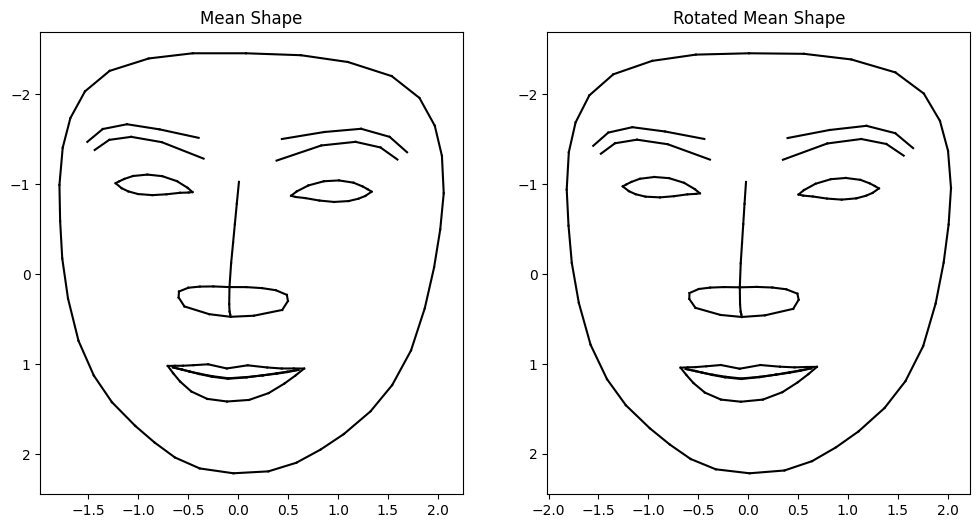

In [49]:
shape = ssm.landmarks_scale[6]
#shape = mean_shape
roatated_shape = rotation.rotate_shape(shape)

connections_contour = rotation.get_plotting_indexes()['full_contour']
plot_landmarks(shape, roatated_shape, connections_contour, color = 'black', linewidth = 1.5)

In [16]:
ssm.landmarks_scale.shape

(126, 478, 2)